# Neural States Analysis

'''Created on Tue 08 Sep 2020'''

Will here explore the posibility that some particular states pops out from the activity traces and look at the correspondient behaviour.

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32363         ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 1
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
            if mouse == 32364:
                fixed = 'UL and UR'
            if mouse == 56165:
                fixed = 'UR and LR (verify)'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
#behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/category_behaviours/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/dlc/states_analysis/'

In [14]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
day = 1
for trial in [1,6,11,16,21]:
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                          '.' + f'{0}' + '_10.pkl'
    timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
    timeline_info = pickle.load(timeline_file)
    ##normalize neural activity
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = activity.shape[1]
    resample_timeline = timeline_1/re_sf

        
    timeline_list.append(resample_timeline)
    
    #beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_event_' + f'{re_sf}' + '.npy'
    #beh_file_name_1 =  'mouse_' + f'{mouse}' + '_session_' + f'{session_now}' +'_day_'+f'{day}'+'_likelihood_0.75.npy'
    beh_file_name_1 =  'mouse_' + f'{mouse}' + '_session_' + f'{session_now}' +'_day_'+f'{day}'+'_likelihood_0.75_inspection.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    #c = np.linspace(0, 20, len(behaviour))
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    resample_timeline = timeline_1/re_sf
    
    behaviour_list.append(resample_beh1)
    day = day + 1

In [6]:
# we compute for each day a matrix containing all the activity
matrix_elements_size= []
neural_corr = []
temporal_corr = []
mean_activity = []
for day in range(len(activity_list)):
    mean_over_trials =  np.mean(activity_list[day], axis= 1)            
    mean_activity.append(mean_over_trials)
    
    matrix_elements_size.append(activity_list[day].shape)
    
    corr_matrix = stats.corr_matrix(neural_activity = activity_list[day])
    neural_corr.append(corr_matrix)
    
    corr_matrix2= stats.corr_matrix(neural_activity = activity_list[day].T)
    temporal_corr.append(corr_matrix2)
    


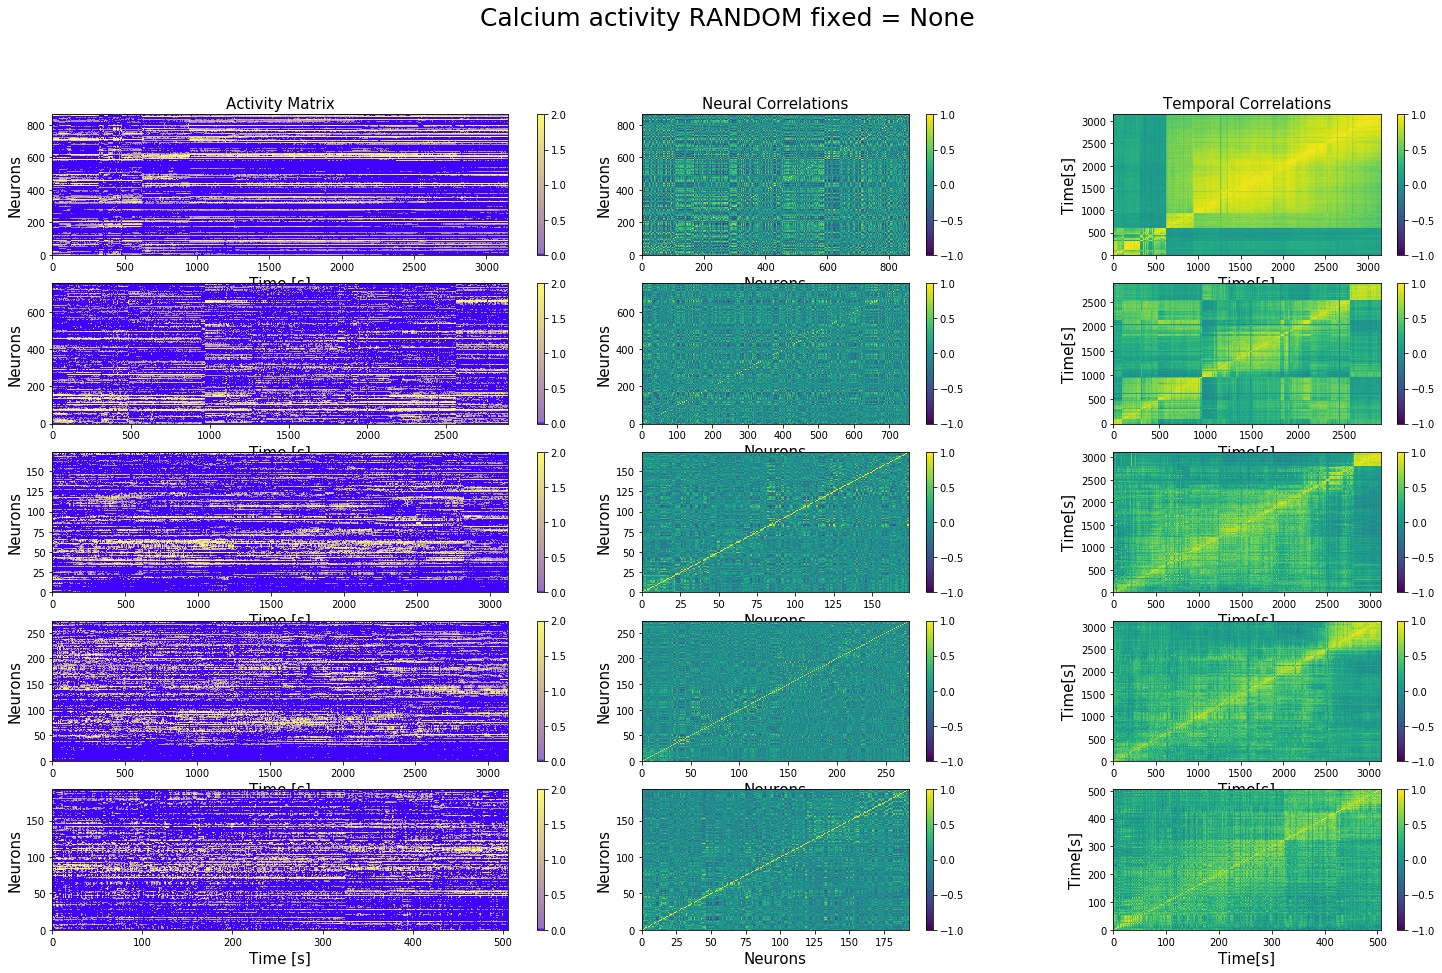

In [6]:
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

vmin= 0
vmax=2

vmin_corr= -1
vmax_corr=1

fig = plt.figure()
gs = plt.GridSpec(5,12)

i=0
for day in range(len(activity_list)):
    ax = fig.add_subplot(gs[day,0:5])
    #ax.set_title()
    ax.set_ylabel('Neurons', fontsize = 15)
    ax.set_xlabel('Time [s]', fontsize = 15)
    mesh = ax.pcolormesh(activity_list[day], cmap = cm)
    mesh.set_clim(vmin,vmax)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Activity Matrix', fontsize = 15)
    
        
    ax = fig.add_subplot(gs[day, 5:8])
    ax.set_ylabel('Neurons', fontsize = 15)
    ax.set_xlabel('Neurons', fontsize = 15)
    mesh = ax.pcolormesh(neural_corr[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Neural Correlations', fontsize = 15)
      
        
    ax = fig.add_subplot(gs[day, 9:12])
    ax.set_ylabel('Time[s]', fontsize = 15)
    ax.set_xlabel('Time[s]', fontsize = 15)
    mesh = ax.pcolormesh(temporal_corr[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Temporal Correlations', fontsize = 15)
    
    
#fig.tight_layout()
fig.set_size_inches(25,15)
fig.suptitle('Calcium activity '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'calcium_activity_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


In [7]:
### compute pca ver matrix of different days
neural_pca_components= []
neural_explained_variance = []
neural_transform=[]
neural_pca = PCA()

temporal_pca = PCA()
data_transform = []
temporal_explained_variance = []
temporal_pca_components= []


for i in range(len(activity_list)):
    neural_pca.fit(activity_list[i].T)
    neural_pca_components.append(neural_pca.components_)
    neural_transform.append(neural_pca.transform(activity_list[i].T))
    neural_explained_variance.append(neural_pca.explained_variance_ratio_)
    
    temporal_pca.fit(activity_list[i])
    data_transform.append(temporal_pca.transform(activity_list[i]))
    temporal_explained_variance.append(temporal_pca.explained_variance_ratio_)
    temporal_pca_components.append(temporal_pca.components_)
    

## Temporal correlations

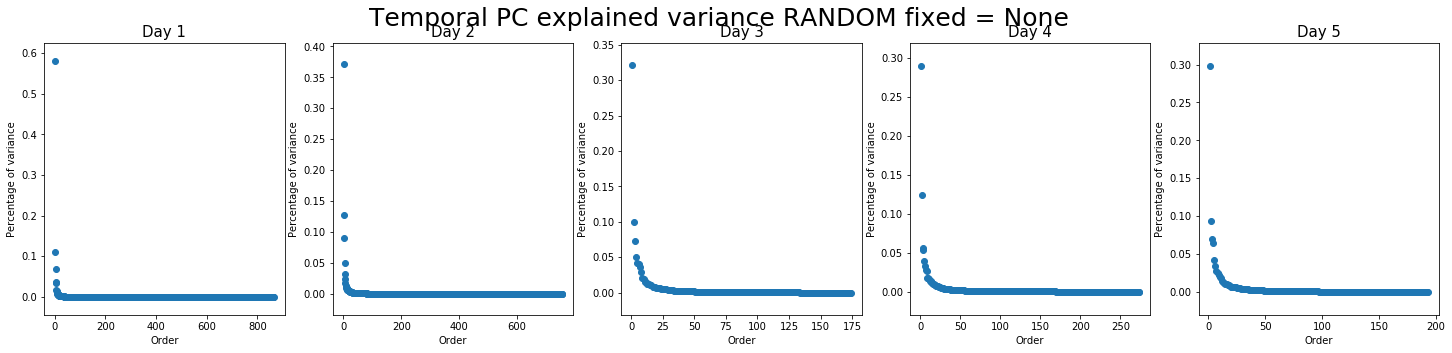

In [8]:
## plot explained variance for each day

fig = plt.figure()
gs = plt.GridSpec(1,5)

for day in range(len(temporal_explained_variance)): 
    ax = fig.add_subplot(gs [0,day])
    ax.scatter(np.arange(1,len(temporal_explained_variance[day])+1,1),temporal_explained_variance[day])
    ax.set_title('Day ' + f'{day+1}', fontsize = 15)
    ax.set_xlabel('Order')
    ax.set_ylabel('Percentage of variance')
fig.set_size_inches(25,5)
fig.suptitle('Temporal PC explained variance '+ task + ' fixed = ' + fixed  , fontsize = 25)
figure_name = figure_path +'temporal_pcs_explained_variance_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

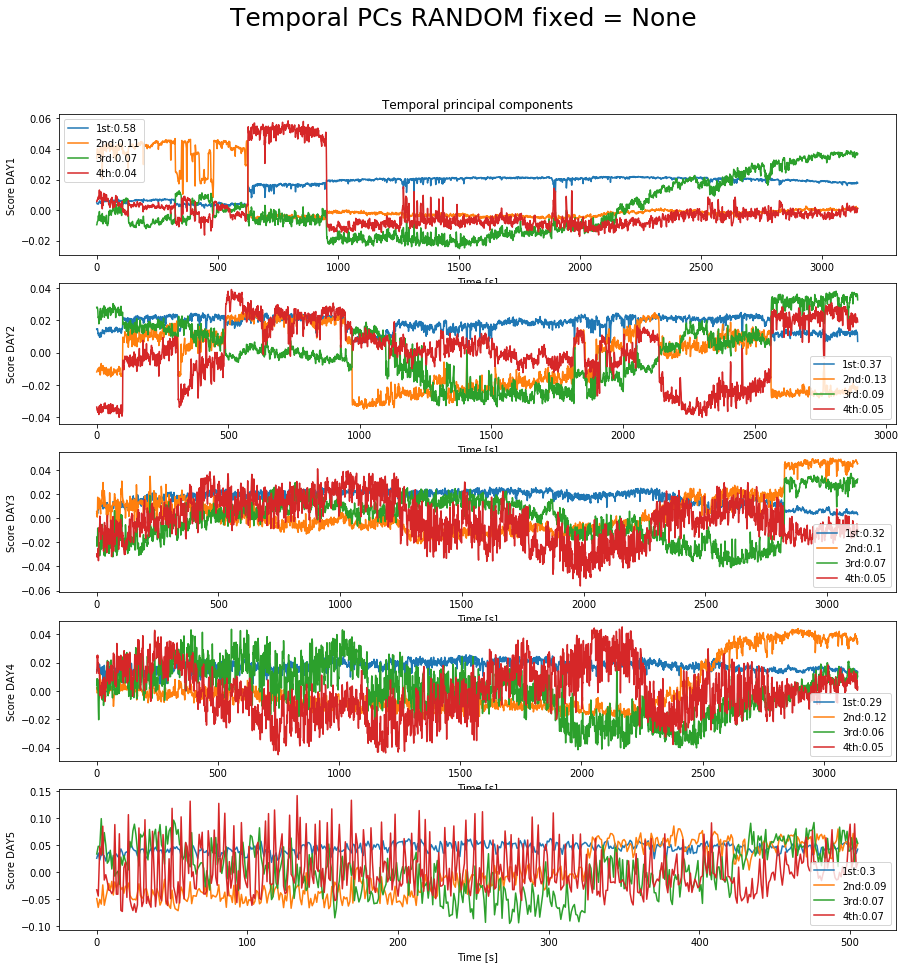

In [9]:
fig = plt.figure()
gs = plt.GridSpec(5, 1)
comp= ['1st','2nd','3rd','4th']


vmin= 0
vmax=1.75

for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0])
    
    ax.plot(temporal_pca_components[day][0,:] / np.linalg.norm(temporal_pca_components[day][0,:]))
    ax.plot(temporal_pca_components[day][1,:] / np.linalg.norm(temporal_pca_components[day][1,:]))
    ax.plot(temporal_pca_components[day][2,:] / np.linalg.norm(temporal_pca_components[day][2,:]))
    ax.plot(temporal_pca_components[day][3,:] / np.linalg.norm(temporal_pca_components[day][3,:]))

    ax.legend([comp[0] + ':' + f'{round(temporal_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(temporal_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(temporal_explained_variance[day][2],2)}',
              comp[3] + ':' + f'{round(temporal_explained_variance[day][3],2)}'])
    if day == 0:
        ax.set_title('Temporal principal components')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Score DAY' + f'{day+1}' )
    #ax.set_ylim([-0.1, 0.35])
    
    

#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Temporal PCs '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'temporal_componets_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

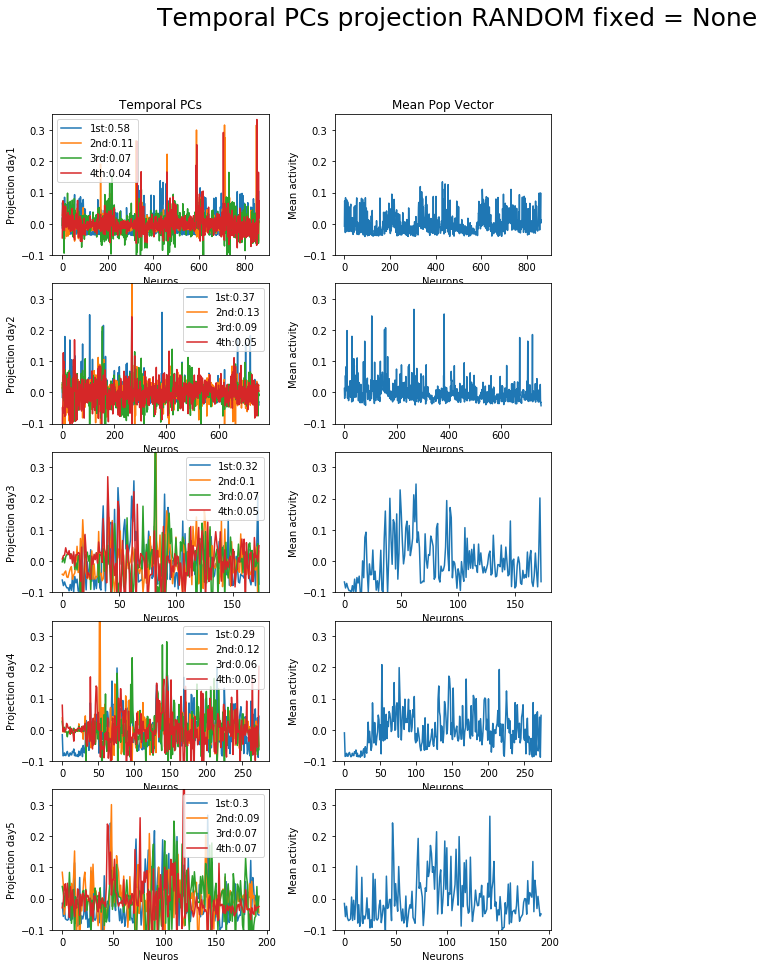

In [10]:
fig = plt.figure()
gs = plt.GridSpec(5, 15)
comp= ['1st','2nd','3rd','4th']


vmin= 0
vmax=1.75

for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:4])
    
    ax.plot(data_transform[day][:,0]/np.linalg.norm(data_transform[day][:,0]))
    ax.plot(data_transform[day][:,1]/np.linalg.norm(data_transform[day][:,1]))
    ax.plot(data_transform[day][:,2]/np.linalg.norm(data_transform[day][:,2]))
    ax.plot(data_transform[day][:,3]/np.linalg.norm(data_transform[day][:,3]))    
    ax.legend([comp[0] + ':' + f'{round(temporal_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(temporal_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(temporal_explained_variance[day][2],2)}',
              comp[3] + ':' + f'{round(temporal_explained_variance[day][3],2)}'])
    if day == 0:
        ax.set_title('Temporal PCs')
    ax.set_xlabel('Neuros')
    ax.set_ylabel('Projection day' + f'{day+1}' )
    ax.set_ylim([-0.1, 0.35])
    
    ax = fig.add_subplot(gs [day,5:9])
    ax.plot(mean_activity[day]/np.linalg.norm(mean_activity[day]))
    if day == 0:
        ax.set_title('Mean Pop Vector')
    ax.set_xlabel('Neurons')
    ax.set_ylabel('Mean activity')
    ax.set_ylim([-0.1, 0.35])
    

#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Temporal PCs projection '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'temporal_pcs_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


In [11]:
# compute distance between each temporal point in the activity matrix and the principal components that are computed
# with the eigenvector analysis

relevant_components = 10
distance_list = []
for day in range(len(activity_list)): 
    distance_matrix = np.zeros((activity_list[day].shape[1],relevant_components))
    for component in range(relevant_components):
        for i in range(activity_list[day].shape[1]):
            #distance = np.linalg.norm(data_transform[day][:,component]/np.linalg.norm(data_transform[day][:,component])-
            #                    activity_list[day][:,i]/np.linalg.norm(activity_list[day][:,i]))
            distance = np.dot(data_transform[day][:,component]/np.linalg.norm(data_transform[day][:,component]),
                             activity_list[day][:,i]/np.linalg.norm(activity_list[day][:,i]))
            distance_matrix[i,component] = distance
    distance_list.append(distance_matrix)

In [12]:
embedded_list = []
for day in range(len(activity_list)): 
    embedded_activity = TSNE(n_components=2, perplexity=30.0, n_iter=3000,).fit_transform(distance_list[day])
    embedded_list.append(embedded_activity)

3150
(3150,)
(3150, 10)
(3150,)
0
1
2
3
4
5
2893
(2893,)
(2893, 10)
(2893,)
0
1
2
3
4
5
3126
(3126,)
(3126, 10)
(3126,)
0
1
2
3
4
5
3141
(3141,)
(3141, 10)
(3141,)
0
1
2
3
4
5
506
(506,)
(506, 10)
(506,)
0
1
2
3
4
5


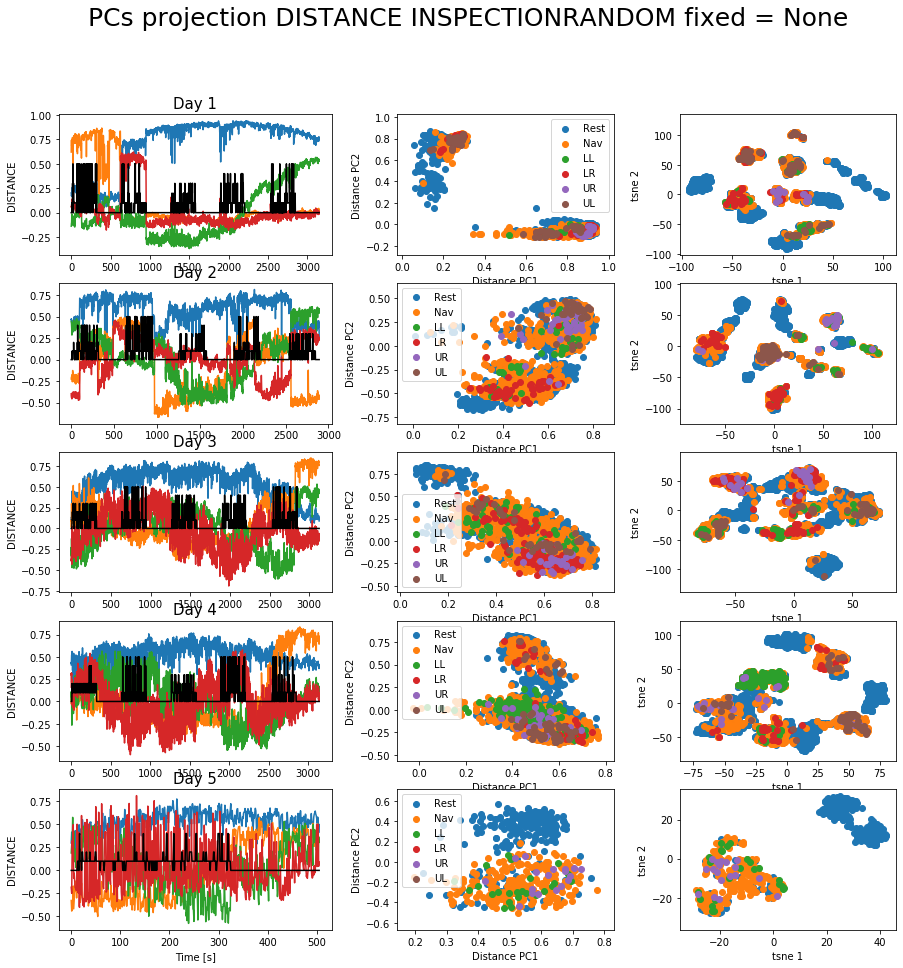

In [16]:
fig = plt.figure()
gs = plt.GridSpec(5, 15)
comp= ['1st','2nd','3rd','4th']

beh = ['Rest','Nav', 'LL', 'LR', 'UR', 'UL']
#beh = ['Rest','Nav', 'Exp']
vmin= 0
vmax=1.75

for day in range(len(activity_list)): 
    print(activity_list[day].shape[1])
    print( behaviour_list[day].shape)
    
    ax = fig.add_subplot(gs[day,0:5])
    ax.plot(distance_list[day][:,0:4])
    ax.plot(behaviour_list[day]/10,'k')
    ax.set_title('Day ' + f'{day+1}', fontsize = 15 )
    if day == len(activity_list)-1:
        ax.set_xlabel('Time [s]')
    ax.set_ylabel('DISTANCE')
    
    ax = fig.add_subplot(gs[day,6:10])#,projection = '3d')
    behaviour_vector= behaviour_list[day].copy()
    #behaviour_vector[np.where(behaviour_vector>=2)]=2
    print(distance_list[day].shape)
    print(behaviour_vector.shape)
    for target in range(6):
        print(target)
        ax.scatter(distance_list[day][np.where(behaviour_vector==target),0],
                  distance_list[day][np.where(behaviour_vector==target),1])#,
                  #distance_list[day][np.where(behaviour_list[day]==target),3])
            
    ax.legend(beh)
    ax.set_xlabel('Distance PC1')
    ax.set_ylabel('Distance PC2')
    
    ax = fig.add_subplot(gs[day,11:15])#,projection = '3d')
    for target in range(6):
        ax.scatter(embedded_list[day][np.where(behaviour_vector==target),0],
                  embedded_list[day][np.where(behaviour_vector==target),1])#,
                  #distance_list[day][np.where(behaviour_list[day]==target),3])
            
    #ax.legend(beh)
    ax.set_xlabel('tsne 1')
    ax.set_ylabel('tsne 2')
    
    
#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle(' PCs projection DISTANCE '+ task + ' fixed = ' + fixed  , fontsize = 25)


figure_name = figure_path +'temporal_pcs_with_behaviour_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


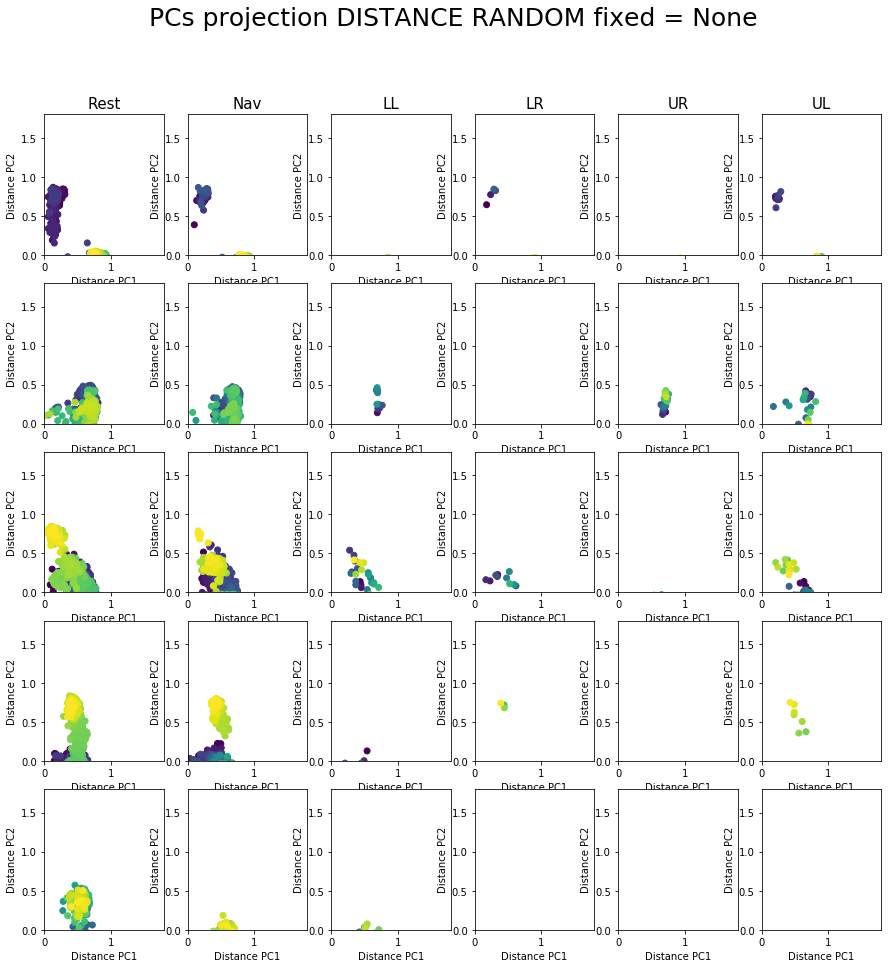

In [21]:
fig = plt.figure()
gs = plt.GridSpec(5, 6)
comp= ['1st','2nd','3rd','4th']

beh = ['Rest','Nav', 'LL', 'LR', 'UR', 'UL']
vmin= 0
vmax=1.8

markers = ['o','*','^','x','.','']

for day in range(len(activity_list)): 
    
    behaviour_vector= behaviour_list[day].copy()
    #behaviour_vector[np.where(behaviour_vector>=2)]=2
    for target in range(6):
        ax = fig.add_subplot(gs[day,target])#, projection = '3d')
        color1 = np.linspace(0, 20, len(distance_list[day][np.where(behaviour_vector==target),0][0]))
        ax.scatter(distance_list[day][np.where(behaviour_vector==target),0][0],
                  distance_list[day][np.where(behaviour_vector==target),1][0],
                  #distance_list[day][np.where(behaviour_list[day]==target),2][0],
                  #marker = markers[target], c = color1)
                   c = color1)
        ax.set_xlim([vmin,vmax])
        ax.set_ylim([vmin,vmax])        
        ax.set_xlabel('Distance PC1')
        ax.set_ylabel('Distance PC2')
        #ax.set_zlabel('Distance PC3')
        if day == 0:
            ax.set_title(beh[target],fontsize = 15)
    
#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle(' PCs projection DISTANCE '+ task + ' fixed = ' + fixed  , fontsize = 25)


figure_name = figure_path +'temporal_pcs_with_behaviour2_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


## Neural correlations 

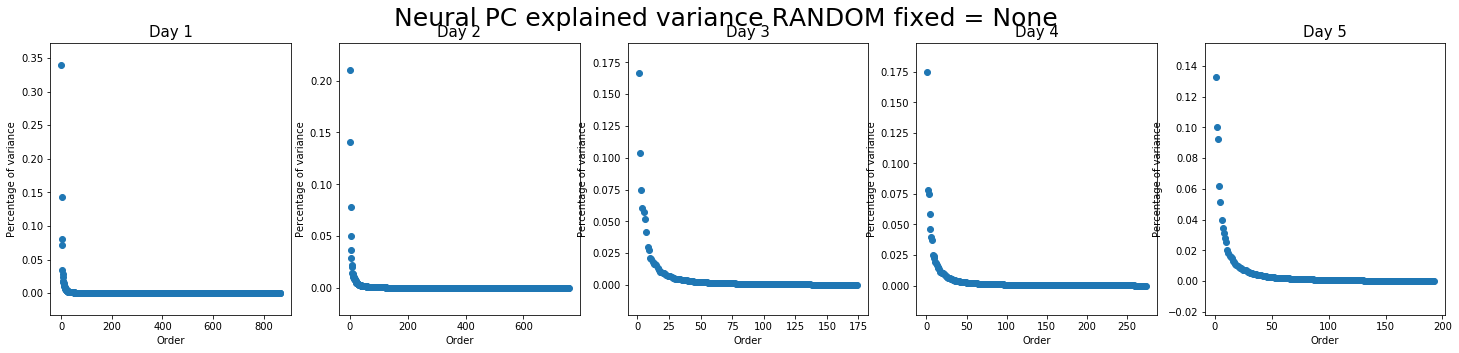

In [22]:
## plot explained variance for each day

fig = plt.figure()
gs = plt.GridSpec(1,5)

for day in range(len(neural_explained_variance)): 
    ax = fig.add_subplot(gs [0,day])
    ax.scatter(np.arange(1,len(neural_explained_variance[day])+1,1),neural_explained_variance[day])
    ax.set_title('Day ' + f'{day+1}', fontsize = 15)
    ax.set_xlabel('Order')
    ax.set_ylabel('Percentage of variance')
fig.set_size_inches(25,5)
fig.suptitle('Neural PC explained variance '+ task + ' fixed = ' + fixed  , fontsize = 25)
figure_name = figure_path +'neural_pcs_explained_variance_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

In [23]:
# compute distance between each temporal point in the activity matrix and the principal components that are computed
# with the eigenvector analysis here with the eigenvectors directly (not the porjection as before)
relevant_components = 5
distance_list_2 = []
for day in range(len(activity_list)): 
    distance_matrix = np.zeros((activity_list[day].shape[1],relevant_components))
    for component in range(relevant_components):
        for i in range(activity_list[day].shape[1]):
            distance = np.linalg.norm(neural_pca_components[day][component,:]/np.linalg.norm(neural_pca_components[day][component,:])-
                                activity_list[day][:,i]/np.linalg.norm(activity_list[day][:,i]))
            distance_matrix[i,component] = distance
    distance_list_2.append(distance_matrix)

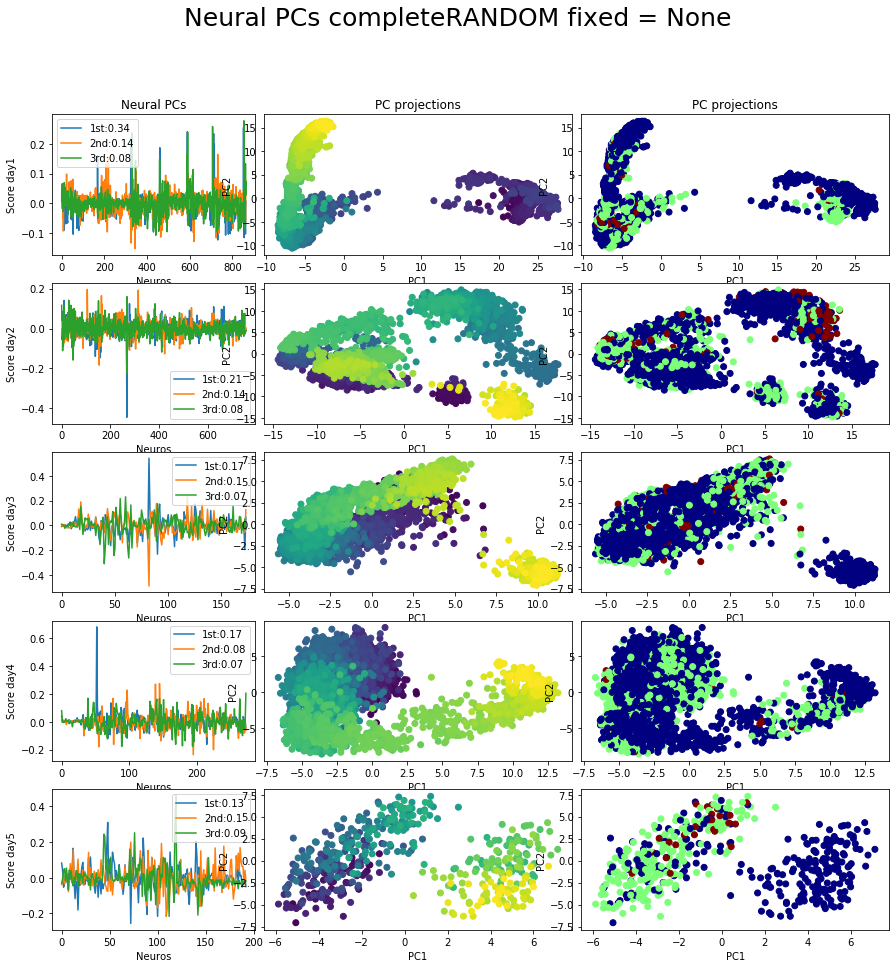

In [24]:
fig = plt.figure()
gs = plt.GridSpec(5, 16)

markers = ['o', '^', '*']

for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:4])
    
    ax.plot(neural_pca_components[day][0,:]/np.linalg.norm(neural_pca_components[day][0,:]))
    ax.plot(neural_pca_components[day][1,:]/np.linalg.norm(neural_pca_components[day][1,:]))
    ax.plot(neural_pca_components[day][2,:]/np.linalg.norm(neural_pca_components[day][2,:]))
   
    ax.legend([comp[0] + ':' + f'{round(neural_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(neural_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(neural_explained_variance[day][2],2)}'])
    if day == 0:
        ax.set_title('Neural PCs')
    ax.set_xlabel('Neuros')
    ax.set_ylabel('Score day' + f'{day+1}' )
    #ax.set_ylim([-0.1, 0.35])
    
    ax = fig.add_subplot(gs [day,4:10])#, projection = '3d')
    
    #for beh in range(len(matrix_elements_size[day])):
    color1 = np.linspace(0, 20, len(neural_transform[day][:,0]))
    ax.scatter(neural_transform[day][:,0],
                neural_transform[day][:,1],
                #neural_transform[day][:,2],
                c = color1)
    
    #ax.legend(['Resting','Navigation','Exploration'])
    if day == 0:
        ax.set_title('PC projections')
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    
    ax = fig.add_subplot(gs [day,10:16])#, projection = '3d')
    
    #for beh in range(len(matrix_elements_size[day])):
    color1 = np.linspace(0, 20, len(neural_transform[day][:,0]))
    beh_color = behaviour_list[day].copy()
    beh_color[np.where(beh_color>=2)]=2
    ax.scatter(neural_transform[day][:,0],
                neural_transform[day][:,1],
                #neural_transform[day][:,2],
                c = beh_color , cmap=cmap)
    
    #ax.legend(['Resting','Navigation','Exploration'])
    if day == 0:
        ax.set_title('PC projections')
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
#fig.tight_layout()
fig.set_size_inches(15,15)
    
#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Neural PCs complete'+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'neural_pcs_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


Text(0.5, 0.98, 'Neural PCs completeRANDOM fixed = None')

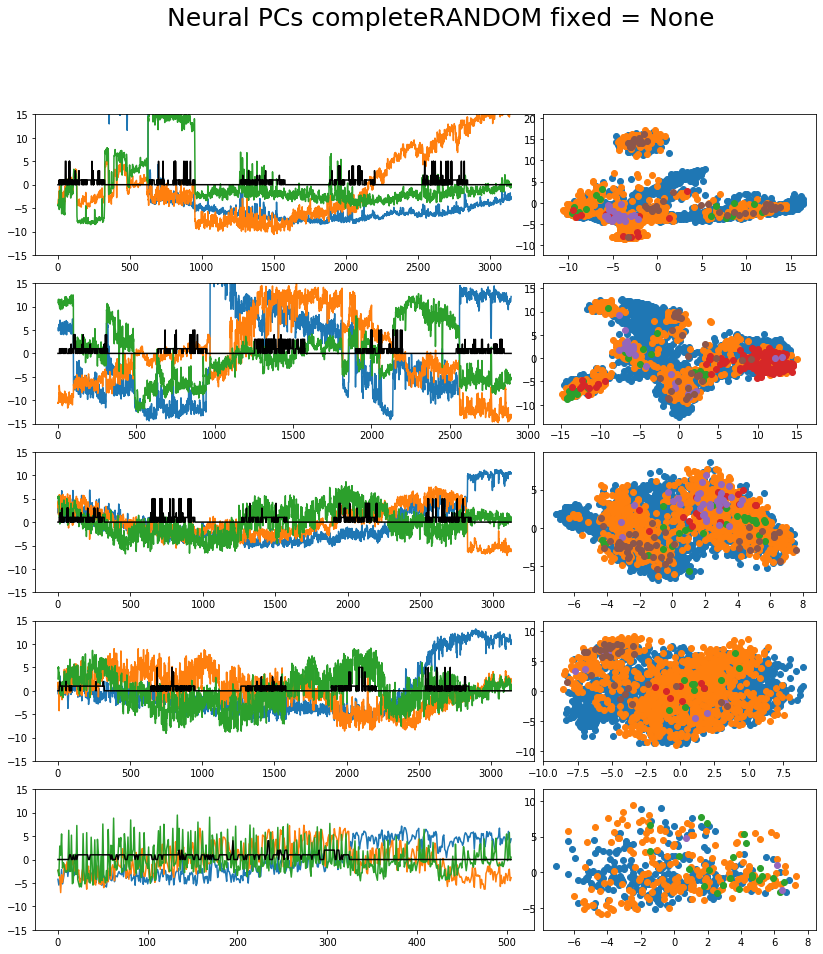

In [25]:
fig = plt.figure()
gs = plt.GridSpec(5, 15)

relevant_components = 3
for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:9])
    #color1 = np.linspace(0, 20, len(neural_transform[day][:,0]))
    for i in range(relevant_components):
        ax.plot(neural_transform[day][:,i])
                #neural_transform[day][:,1],
                #neural_transform[day][:,2],
                #marker = markers[beh], c = color1)
    ax.plot(behaviour_list[day],'k')
        
    ax.set_ylim([-15, 15])

    
    ax = fig.add_subplot(gs[day,9:14])#,projection = '3d')
    behaviour_vector= behaviour_list[day].copy()
    #behaviour_vector[np.where(behaviour_vector>=2)]=2
    for target in range(6):
        ax.scatter(neural_transform[day][np.where(behaviour_vector==target)[0],1],
                  neural_transform[day][np.where(behaviour_vector==target)[0],2])
                  # neural_transform[day][np.where(behaviour_vector==target)[0],2] )#,
            
    
#fig.tight_layout()
fig.set_size_inches(15,15)
    
fig.suptitle('Neural PCs complete'+ task + ' fixed = ' + fixed  , fontsize = 25)


## tSNE on principal components of neural PC

In [26]:
relevant_tsne_components = 10

In [27]:
embedded_list = []
for day in range(len(activity_list)-1): 
    embedded_activity = TSNE(n_components=2, perplexity=30.0, n_iter=3000,).fit_transform(neural_transform[day][:,0:relevant_tsne_components])
    embedded_list.append(embedded_activity)

KeyboardInterrupt: 

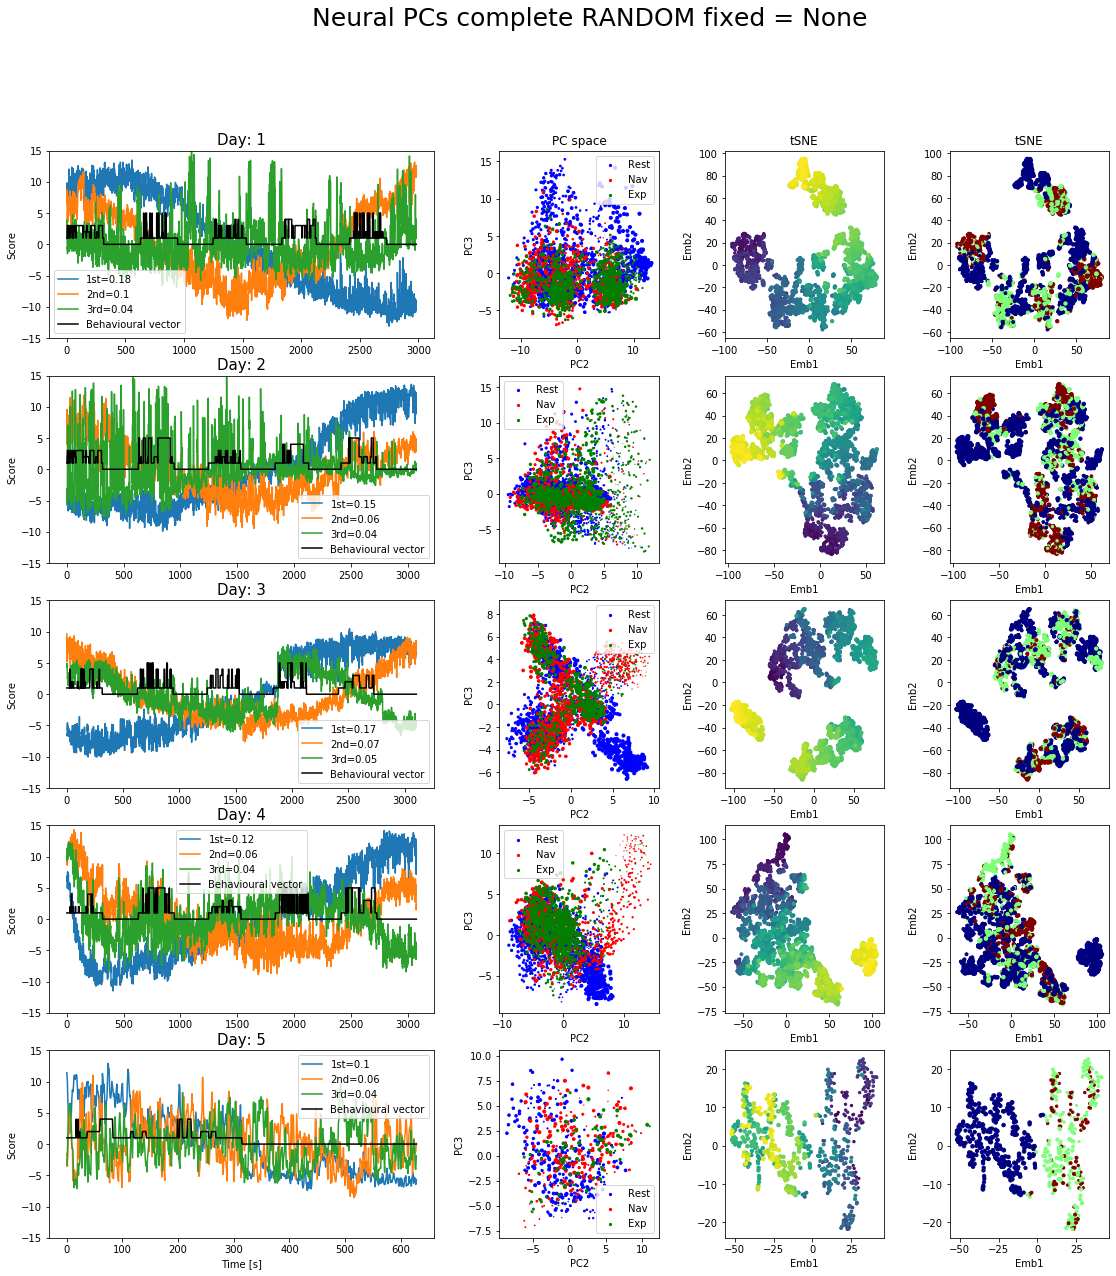

In [15]:
fig = plt.figure()
gs = plt.GridSpec(5, 20)

relevant_components = 3
for day in range(len(activity_list)): 
    
    ax = fig.add_subplot(gs [day,0:7])
    for i in range(relevant_components):
        ax.plot(neural_transform[day][:,i])
                #neural_transform[day][:,1],
                #neural_transform[day][:,2],
                #marker = markers[beh], c = color1)
    ax.plot(behaviour_list[day],'k')
    ax.set_ylim([-15, 15])
    ax.set_ylabel('Score')
    ax.set_title('Day: '+ f'{day+1}', fontsize = 15)
    if day == len(activity_list)-1:
        ax.set_xlabel('Time [s]')
    ax.legend(['1st='+f'{round(neural_explained_variance[day][0],2)}',
               '2nd='+f'{round(neural_explained_variance[day][1],2)}',
              '3rd='+f'{round(neural_explained_variance[day][2],2)}',
             #  '4th='+f'{round(neural_explained_variance[day][3],2)}',
             # '5th='+f'{round(neural_explained_variance[day][4],2)}',
              'Behavioural vector'])

    ax = fig.add_subplot(gs[day,8:11])#,projection = '3d')
    
    beh_color = behaviour_list[day].copy()
    beh_color[np.where(beh_color>=2)]=2 
    target_color = ['b', 'r', 'g']
    for target in range(3):
        scatter_size = np.linspace(0,10,len(neural_transform[day][np.where(beh_color==target)[0],1]))
        ax.scatter(neural_transform[day][np.where(beh_color==target)[0],1],
                  neural_transform[day][np.where(beh_color==target)[0],2],
                   scatter_size,
                   c = target_color[target])
                  # neural_transform[day][np.where(behaviour_vector==target)[0],2] )#,
    if day == 0:
        ax.set_title('PC space')
    ax.set_xlabel('PC2')
    ax.set_ylabel('PC3')
    ax.legend(['Rest', 'Nav', 'Exp'])
    
    ax = fig.add_subplot(gs[day, 12:15])
    color = np.linspace(0, 20, embedded_list[day].shape[0])
    scatter_size = np.linspace(5,15,embedded_list[day].shape[0])
    ax.scatter(embedded_list[day][:,0],embedded_list[day][:,1], scatter_size,c=color)#, cmap=cmap)
    if day == 0:
        ax.set_title('tSNE')
    ax.set_xlabel('Emb1')
    ax.set_ylabel('Emb2')
    
    ax = fig.add_subplot(gs[day, 16:19])
    beh_color = behaviour_list[day].copy()
    beh_color[np.where(beh_color>=2)]=2
    ax.scatter(embedded_list[day][:,0],embedded_list[day][:,1],  scatter_size, c=beh_color, cmap=cmap)
    if day == 0:
        ax.set_title('tSNE')
    ax.set_xlabel('Emb1')
    ax.set_ylabel('Emb2')
    
#fig.tight_layout()
fig.set_size_inches(20,20)
    
fig.suptitle('Neural PCs complete '+ task + ' fixed = ' + fixed  , fontsize = 25)


figure_name = figure_path +'neural_pcs_projection_complete_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

## Comparison between exploration patterns and resting periods

In this case we will compare an n-dimensional pc component correlation matrix from exploration periods with the n-dimensional exploration pattern in the resting period, using the previous and the following resting periods of each trial. 

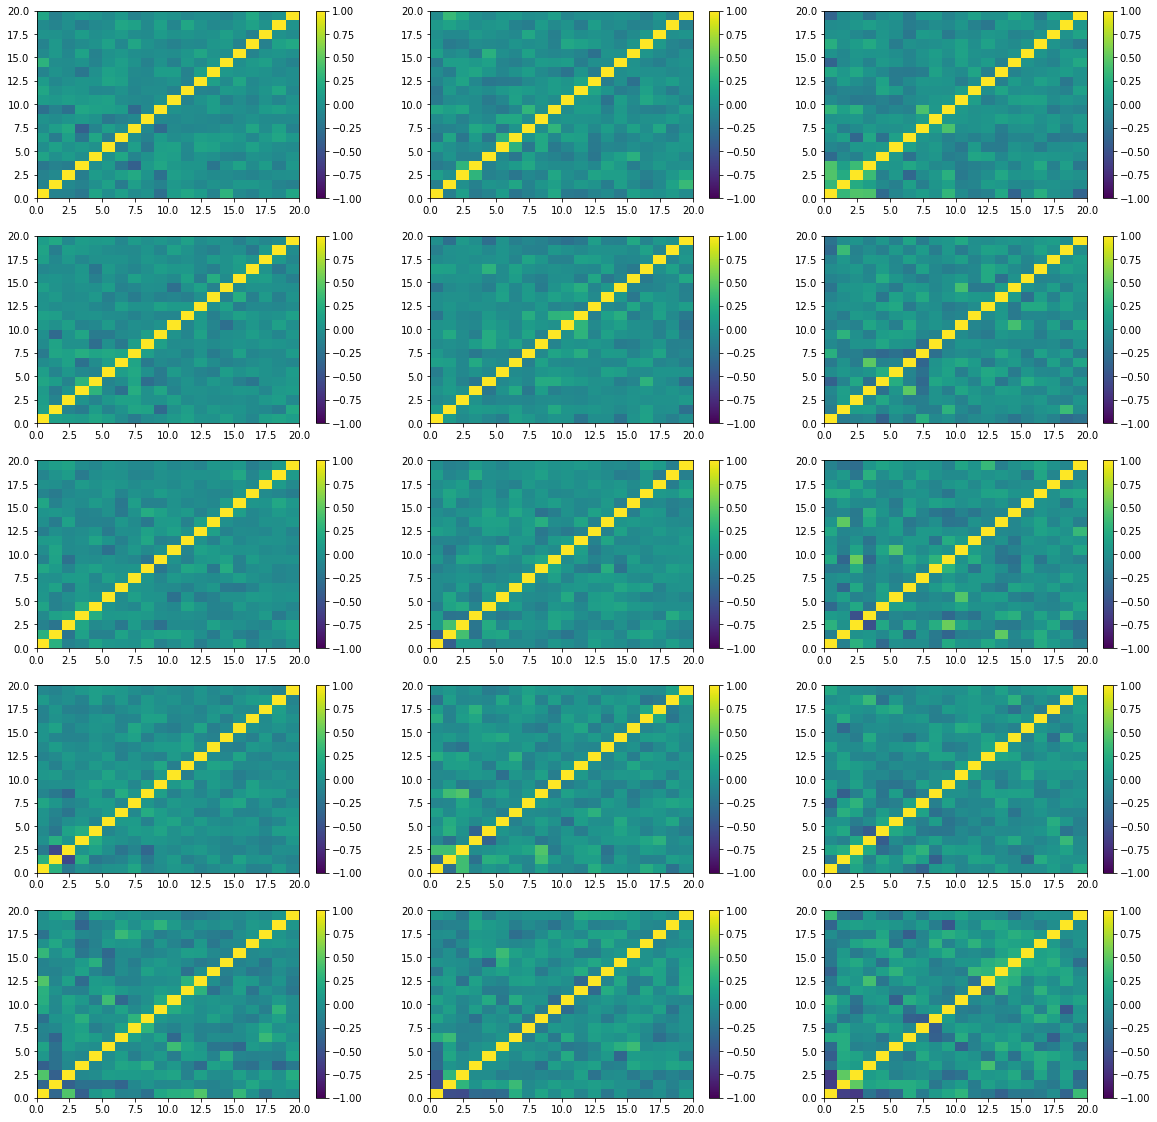

In [85]:
fig = plt.figure()
gs = plt.GridSpec(5, 3)

vmin_corr = -1
vmax_corr = 1

for day in range(len(neural_transform)):
    #create behaviour vector with resting, navigation and exploring for each day
    beh_data = behaviour_list[day].copy()
    beh_data[np.where(beh_data>=2)]=2 
    matrix_behaviour = []
    correlation_behaviour = []
    #construct matrix with data from each behaviour
    for target in range(3):
        data_target = np.where(beh_data == target)[0]
        matrix_behaviour.append(neural_transform[day][data_target,:])
        complete_corr = stats.corr_matrix(neural_activity = neural_transform[day][data_target,:].T)
        correlation_behaviour.append(complete_corr)
        
        ax = fig.add_subplot(gs [day,target])
        #ax.imshow(complete_corr)
        mesh = ax.pcolormesh(complete_corr, cmap = 'viridis')
        mesh.set_clim(vmin_corr,vmax_corr)
        fig.colorbar(mesh,ax=ax)

#fig.tight_layout()
fig.set_size_inches(20,20)
    

In [81]:
fig = plt.figure()
gs = plt.GridSpec(5, 3)
correlation_day = []

for day in range(len(neural_transform)):
    #create behaviour vector with resting, navigation and exploring for each day
    beh_data = behaviour_list[day].copy()
    beh_data[np.where(beh_data>=2)]=2 
    correlation_behaviour = []
    #construct matrix with data from each behaviour
    for target in range(3):
        correlation_behaviour_target = []
        for i in range(1,len(timeline_list[day])-1):
            data = beh_data[int(timeline_list[day][i]):int(timeline_list[day][i+1])]
            data_target = np.where(data == target)[0]
            complete_corr = stats.corr_matrix(neural_activity = neural_transform[day][data_target,:].T)
            correlation_behaviour_target.append(complete_corr)
        correlation_behaviour.append(correlation_behaviour_target)
    correlation_day.append(correlation_behaviour)

/home/melisa/Documents/neural_analysis/src/general_statistics.py:75: RuntimeWarning: invalid value encountered in true_divide
  corr_matrix = corr_matrix / (n_time-1)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, o

<Figure size 432x288 with 0 Axes>

Days: 5
Behaviours:  3
Set of trials: 4


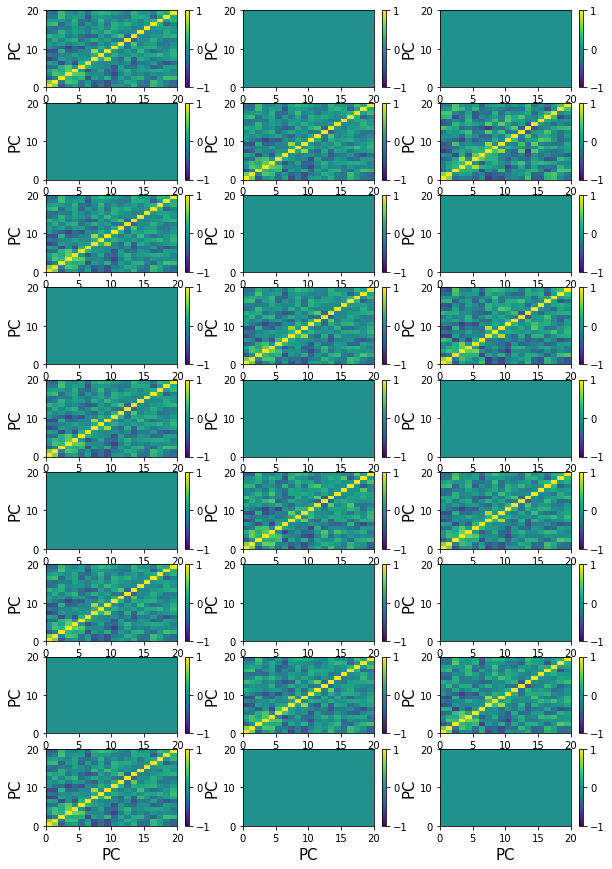

In [88]:
fig = plt.figure()
gs = plt.GridSpec(9, 3)

print('Days:',len(correlation_day))
print('Behaviours: ', len(correlation_day[0]))
print('Set of trials:' , round(len(correlation_day[0][0])/2))

vmin_corr = -1
vmax_corr = 1

for trial in range(len(correlation_day[0][0])):
    for beh in range(len(correlation_day[0])):
        ax = fig.add_subplot(gs [trial,beh])
        mesh = ax.pcolormesh(correlation_day[0][beh][trial], cmap = 'viridis')
        mesh.set_clim(vmin_corr,vmax_corr)
        fig.colorbar(mesh,ax=ax)
        ax.set_ylabel('PC', fontsize = 15)
        ax.set_xlabel('PC', fontsize = 15)
    
#fig.tight_layout()
fig.set_size_inches(10,15)
    

In [83]:
trial_resting = [0,2,4,6,8]
trial_exploration = [1,3,5,7]

pcorr_pre = []
pcorr_post = []

for day in range(len(correlation_day)):
    pcorr_day_pre = []
    pcorr_day_post = []
        
    for trial in trial_exploration:
        x = np.tril_indices_from(correlation_day[day][0][trial-1],k=-1)
        data0 = correlation_day[day][0][trial-1][x]
        data1 = correlation_day[day][2][trial][x]
        data2 = correlation_day[day][0][trial+1][x]
        
        pcorr0 = np.corrcoef(data0,data1)
        pcorr1 = np.corrcoef(data1,data2)
        
        pcorr_day_pre.append(pcorr0[0,1])
        pcorr_day_post.append(pcorr1[0,1])
    
    pcorr_pre.append(pcorr_day_pre)
    pcorr_post.append(pcorr_day_post)

/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


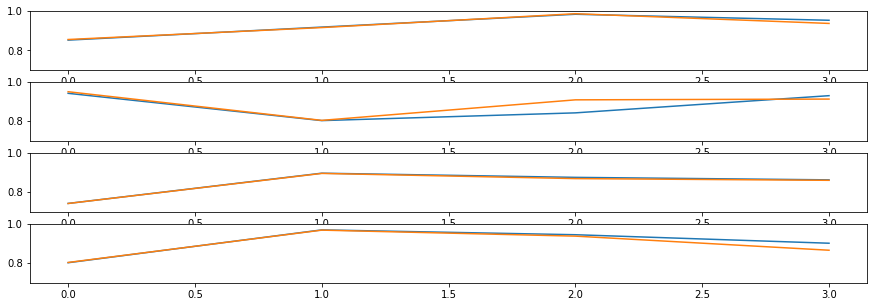

In [84]:
fig = plt.figure()
gs = plt.GridSpec(4,1)

for day in range(len(correlation_day)-1):
    ax = fig.add_subplot(gs [day,0])
    ax.plot(pcorr_pre[day])
    ax.plot(pcorr_post[day])
    ax.set_ylim([0.7,1])
    
fig.set_size_inches(15,5)
